# 📰 News Data Exploration

**Goal**: Understand the raw news data we downloaded from Alpha Vantage before using it for sentiment analysis.

We'll answer four key questions:
1. **How many articles per day?** — Is our coverage consistent or are there gaps?
2. **What sources are most common?** — Who's producing the news we're analyzing?
3. **Average article length?** — Do we have enough text for sentiment analysis?
4. **Are there data quality issues?** — Missing values, duplicates, irrelevant articles?

**Data source**: `data/raw/news_<TICKER>_2025-11-01_to_2026-02-13.csv` (downloaded via Alpha Vantage)

## Step 1 — Load the data

We load both news CSV files (AAPL and MSFT) and combine them into a single DataFrame for unified analysis. We also parse dates and add a helper column for article text length.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Path to our raw data folder
RAW_DATA_DIR = Path("../../data/raw")

# Load news CSVs for both tickers and combine into one DataFrame
aapl_news = pd.read_csv(RAW_DATA_DIR / "news_AAPL_2025-11-01_to_2026-02-13.csv")
msft_news = pd.read_csv(RAW_DATA_DIR / "news_MSFT_2025-11-01_to_2026-02-13.csv")

news = pd.concat([aapl_news, msft_news], ignore_index=True)

# Parse published_at as datetime
news["published_at"] = pd.to_datetime(news["published_at"], errors="coerce")

# Add a date-only column (useful for daily aggregations)
news["date"] = news["published_at"].dt.date

# Add article length columns (character count of summary and title)
news["summary_length"] = news["summary"].fillna("").str.len()
news["title_length"] = news["title"].fillna("").str.len()

print(f"Loaded {len(news)} total articles ({len(aapl_news)} AAPL + {len(msft_news)} MSFT)")
print(f"Date range: {news['published_at'].min()} → {news['published_at'].max()}")
news.head(3)

Loaded 100 total articles (50 AAPL + 50 MSFT)
Date range: 2026-02-09 17:59:49 → 2026-02-12 22:27:44


,title,summary,source,url,published_at,authors,overall_sentiment_score,overall_sentiment_label,ticker_sentiment_score,ticker_sentiment_label,ticker,date,summary_length,title_length
0,Apple has worst day since April as company fac...,Apple experienced its worst stock market day s...,CNBC,https://www.cnbc.com/2026/02/12/apple-stock-wo...,2026-02-12 21:56:42,Jennifer Elias,-0.601882,Bearish,-0.606083,Bearish,AAPL,2026-02-12,440,81
1,LiveOne Inc (LVO) Q3 2026 Earnings Call Highli...,LiveOne Inc (LVO) reported robust Q3 2026 fina...,GuruFocus,https://www.gurufocus.com/news/8612260/liveone...,2026-02-12 21:28:12,GuruFocus News,0.187793,Somewhat-Bullish,0.132754,Neutral,AAPL,2026-02-12,466,130
2,"Eversource Energy earnings missed, revenue top...",Eversource Energy (NYSE: ES) reported its Q4 e...,Investing.com,https://www.investing.com/news/earnings/everso...,2026-02-12 21:27:11,Investing.com,-0.174349,Somewhat-Bearish,-0.229515,Somewhat-Bearish,AAPL,2026-02-12,363,59


## Step 2 — How many articles per day?

Understanding the daily volume of articles helps us know:
- Whether we have **consistent coverage** across the date range
- If there are **gaps** (days with no articles — e.g., weekends, holidays)
- Whether certain days see **spikes** (e.g., earnings announcements, big news events)

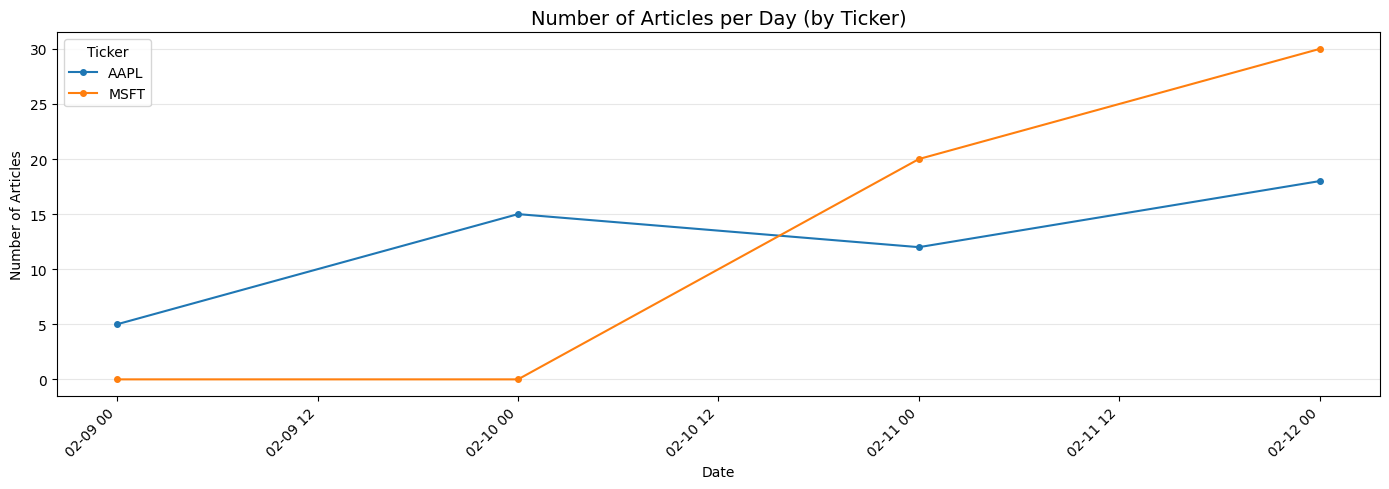


Days with articles: 4
Articles per day — min: 5, max: 48, mean: 25.0, median: 24


In [7]:
# Count articles per day, broken down by ticker
daily_counts = news.groupby(["date", "ticker"]).size().unstack(fill_value=0)

# Use a line chart — much clearer than stacked bars for time series
fig, ax = plt.subplots(figsize=(14, 5))

for ticker in daily_counts.columns:
    ax.plot(daily_counts.index, daily_counts[ticker], marker="o", markersize=4, label=ticker)

ax.set_title("Number of Articles per Day (by Ticker)", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Number of Articles")
ax.legend(title="Ticker")
ax.grid(axis="y", alpha=0.3)

# Format x-axis dates properly
fig.autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
total_days = daily_counts.shape[0]
total_per_day = daily_counts.sum(axis=1)
print(f"\nDays with articles: {total_days}")
print(f"Articles per day — min: {total_per_day.min()}, max: {total_per_day.max()}, "
      f"mean: {total_per_day.mean():.1f}, median: {total_per_day.median():.0f}")

## Step 3 — What sources are most common?

Knowing which news sources dominate our dataset helps us understand potential **bias**. If most articles come from a single source, our sentiment analysis might reflect that source's editorial tone rather than the market's overall sentiment.

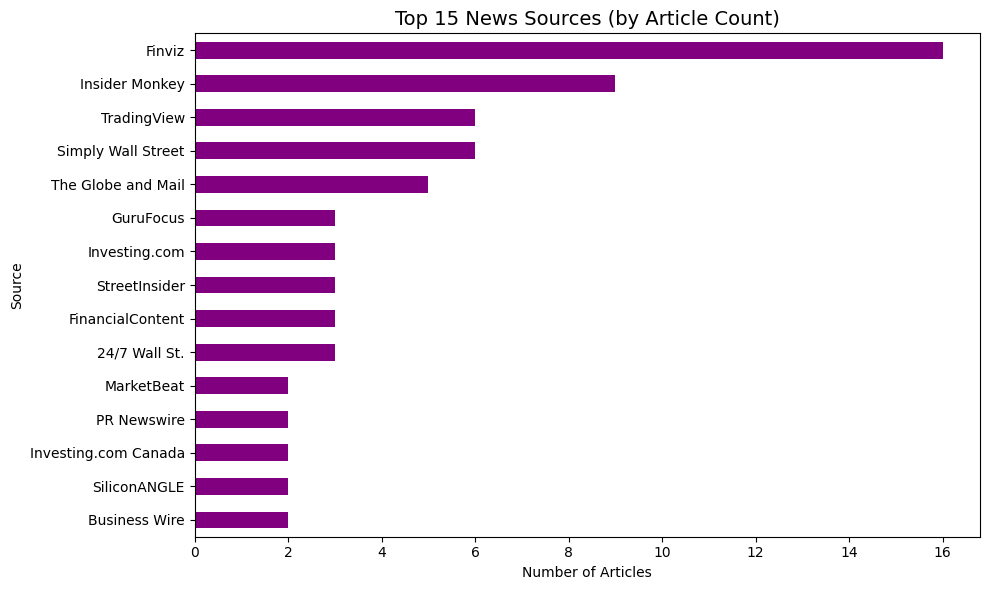


Total unique sources: 47
Top 3 sources account for 31 / 100 articles (31.0%)


In [12]:
# Top 15 news sources by number of articles
source_counts = news["source"].value_counts().head(15)

fig, ax = plt.subplots(figsize=(10, 6))
source_counts.plot(kind="barh", ax=ax, color="purple")
ax.set_title("Top 15 News Sources (by Article Count)", fontsize=14)
ax.set_xlabel("Number of Articles")
ax.set_ylabel("Source")
ax.invert_yaxis()  # Most common source at the top
plt.tight_layout()
plt.show()

# Print how many unique sources we have
print(f"\nTotal unique sources: {news['source'].nunique()}")
print(f"Top 3 sources account for {source_counts.head(3).sum()} / {len(news)} articles "
      f"({source_counts.head(3).sum() / len(news) * 100:.1f}%)")

## Step 4 — Average article length

Sentiment models need enough text to work with. Very short articles (just a headline) may not carry enough signal, while very long ones might dilute it. We look at the **summary** length since that's the text we'll likely feed into our model (Alpha Vantage provides summaries, not full article bodies).

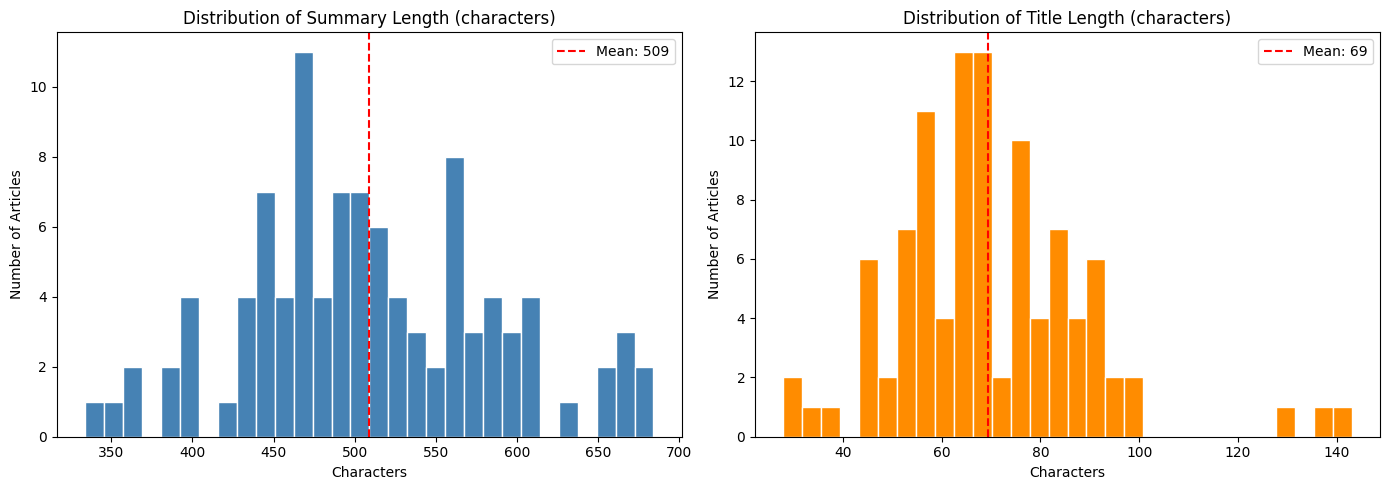

Summary length stats (characters):
count    100.000000
mean     508.630000
std       77.047494
min      334.000000
25%      460.750000
50%      500.500000
75%      564.000000
max      684.000000

Articles with empty summaries: 0


In [5]:
# Distribution of summary lengths
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of summary lengths
axes[0].hist(news["summary_length"], bins=30, color="steelblue", edgecolor="white")
axes[0].set_title("Distribution of Summary Length (characters)", fontsize=12)
axes[0].set_xlabel("Characters")
axes[0].set_ylabel("Number of Articles")
axes[0].axvline(news["summary_length"].mean(), color="red", linestyle="--", label=f'Mean: {news["summary_length"].mean():.0f}')
axes[0].legend()

# Histogram of title lengths
axes[1].hist(news["title_length"], bins=30, color="darkorange", edgecolor="white")
axes[1].set_title("Distribution of Title Length (characters)", fontsize=12)
axes[1].set_xlabel("Characters")
axes[1].set_ylabel("Number of Articles")
axes[1].axvline(news["title_length"].mean(), color="red", linestyle="--", label=f'Mean: {news["title_length"].mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print summary stats
print("Summary length stats (characters):")
print(news["summary_length"].describe().to_string())
print(f"\nArticles with empty summaries: {(news['summary_length'] == 0).sum()}")

## Step 5 — Data quality issues

Before using this data for modeling, we need to check for common problems:
- **Missing values** — Are any critical columns empty?
- **Duplicate articles** — The same article might appear for both tickers
- **Irrelevant articles** — Articles that mention the ticker but aren't really about it
- **Sentiment coverage** — Do all articles have sentiment scores?

In [6]:
# --- 5a. Missing values per column ---
print("=" * 50)
print("MISSING VALUES PER COLUMN")
print("=" * 50)
missing = news.isnull().sum()
missing_pct = (missing / len(news) * 100).round(1)
missing_report = pd.DataFrame({"missing": missing, "percent": missing_pct})
print(missing_report[missing_report["missing"] > 0].to_string() 
      if missing.any() else "No missing values found!")

# --- 5b. Duplicate articles (same title appearing for different tickers) ---
print("\n" + "=" * 50)
print("DUPLICATE ARTICLES")
print("=" * 50)
duplicate_titles = news.duplicated(subset=["title"], keep=False)
n_duplicates = duplicate_titles.sum()
print(f"Articles with duplicate titles: {n_duplicates} ({n_duplicates / len(news) * 100:.1f}%)")
if n_duplicates > 0:
    print("\nExample duplicates (same article, different tickers?):")
    print(news[duplicate_titles][["title", "ticker", "source"]].head(6).to_string(index=False))

# --- 5c. Sentiment score coverage ---
print("\n" + "=" * 50)
print("SENTIMENT SCORE COVERAGE")
print("=" * 50)
no_ticker_sentiment = news["ticker_sentiment_score"].isnull().sum()
print(f"Articles missing ticker-specific sentiment: {no_ticker_sentiment} "
      f"({no_ticker_sentiment / len(news) * 100:.1f}%)")
print(f"\nSentiment label distribution (overall):")
print(news["overall_sentiment_label"].value_counts().to_string())

# --- 5d. Date parsing issues ---
print("\n" + "=" * 50)
print("DATE PARSING")
print("=" * 50)
bad_dates = news["published_at"].isnull().sum()
print(f"Articles with unparseable dates: {bad_dates}")

MISSING VALUES PER COLUMN
         missing  percent
authors       21     21.0

DUPLICATE ARTICLES
Articles with duplicate titles: 21 (21.0%)

Example duplicates (same article, different tickers?):
                                                              title ticker             source
                                       Form 424B2 BARCLAYS BANK PLC   AAPL      StreetInsider
   Alphabet Drops 7% Post Q4 Earnings: Buy, Sell or Hold the Stock?   AAPL The Globe and Mail
   Alphabet Drops 7% Post Q4 Earnings: Buy, Sell or Hold the Stock?   AAPL        TradingView
Coherent Faces Ownership Shift As Texas Grant Supports Growth Plans   AAPL Simply Wall Street
Coherent Faces Ownership Shift As Texas Grant Supports Growth Plans   AAPL Simply Wall Street
   FMR LLC Reduces Stake in Amdocs Ltd: A Strategic Portfolio Adjus   AAPL          GuruFocus

SENTIMENT SCORE COVERAGE
Articles missing ticker-specific sentiment: 0 (0.0%)

Sentiment label distribution (overall):
overall_sentiment_label
S

## Step 6 — Sentiment score distribution (Alpha Vantage baseline)

Alpha Vantage provides pre-computed sentiment scores with each article. This gives us a **baseline** to compare against when we build our own FinBERT model later.

- `overall_sentiment_score`: how positive/negative the entire article is (-1 to +1)
- `ticker_sentiment_score`: how positive/negative the article is **specifically about our ticker** (-1 to +1)

We want to see: Is the news mostly bullish, neutral, or bearish? Does it differ between AAPL and MSFT?

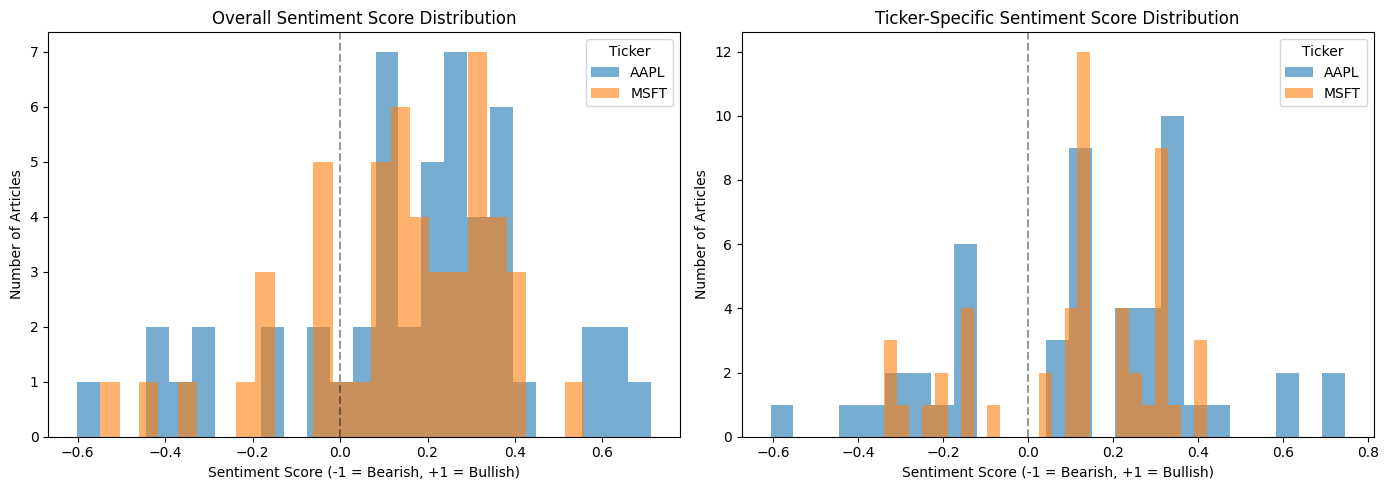

Mean sentiment scores by ticker:
        overall_sentiment_score  ticker_sentiment_score
ticker                                                 
AAPL                      0.165                   0.135
MSFT                      0.131                   0.113

Sentiment label breakdown by ticker:
overall_sentiment_label  Bearish  Bullish  Neutral  Somewhat-Bearish  Somewhat-Bullish
ticker                                                                                
AAPL                           4       11       12                 4                19
MSFT                           2        8       17                 5                18


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 6a. Overall sentiment score distribution, by ticker ---
for ticker in ["AAPL", "MSFT"]:
    subset = news[news["ticker"] == ticker]
    axes[0].hist(subset["overall_sentiment_score"], bins=25, alpha=0.6, label=ticker)

axes[0].set_title("Overall Sentiment Score Distribution", fontsize=12)
axes[0].set_xlabel("Sentiment Score (-1 = Bearish, +1 = Bullish)")
axes[0].set_ylabel("Number of Articles")
axes[0].axvline(0, color="black", linestyle="--", alpha=0.4)
axes[0].legend(title="Ticker")

# --- 6b. Ticker-specific sentiment score distribution ---
for ticker in ["AAPL", "MSFT"]:
    subset = news[(news["ticker"] == ticker) & (news["ticker_sentiment_score"].notna())]
    axes[1].hist(subset["ticker_sentiment_score"], bins=25, alpha=0.6, label=ticker)

axes[1].set_title("Ticker-Specific Sentiment Score Distribution", fontsize=12)
axes[1].set_xlabel("Sentiment Score (-1 = Bearish, +1 = Bullish)")
axes[1].set_ylabel("Number of Articles")
axes[1].axvline(0, color="black", linestyle="--", alpha=0.4)
axes[1].legend(title="Ticker")

plt.tight_layout()
plt.show()

# Print mean sentiment per ticker
print("Mean sentiment scores by ticker:")
print(news.groupby("ticker")[["overall_sentiment_score", "ticker_sentiment_score"]].mean().round(3).to_string())

# Sentiment label breakdown per ticker
print("\nSentiment label breakdown by ticker:")
print(news.groupby(["ticker", "overall_sentiment_label"]).size().unstack(fill_value=0).to_string())